# Installing Dependencies


In [4]:
import os
import numpy as np
import tensorflow as tf
import pretty_midi
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


### Setting up GPU
#### Making sure GPU is utilized

In [2]:
import psutil
import tensorflow as tf

ram = psutil.virtual_memory()
print(f"Total RAM: {ram.total / (1024**3):.2f} GB")
print(f"Available RAM: {ram.available / (1024**3):.2f} GB")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]  # 1GB VRAM
            )
    except RuntimeError as e:
        print(e)


Total RAM: 7.59 GB
Available RAM: 6.46 GB


## Loading the MIDI Files
---
#### I have kept the length of each sequence to be equal to 50. <br>
##### The sequence can be changed by changing the value of 
<code>
<u>'seq_length'</u>
</code>

##### in
<code>
def load_midi_files(directory, <u>seq_length</u>=50, max_files=500):</code>

##### or 
<code>sequences = load_midi_files("midi/", <u>seq_length</u>=50)</code>

In [5]:
def load_midi_files(directory, seq_length=50, max_files=500):
    """Load and process MIDI files into sequences"""
    sequences = []
    programs = set()
    
    for root, _, files in os.walk(directory):
        for f in files[:max_files]:
            if f.endswith('.mid'):
                try:
                    midi = pretty_midi.PrettyMIDI(os.path.join(root, f))
                    instrument = midi.instruments[0]
                    notes = sorted(instrument.notes, key=lambda x: x.start)
                    
                    # Convert to sequence format
                    seq = []
                    prev_start = notes[0].start
                    for note in notes:
                        seq.append([
                            note.pitch,
                            note.end - note.start,  # duration
                            note.start - prev_start  # step
                        ])
                        prev_start = note.start
                    
                    # Split into fixed-length sequences
                    for i in range(0, len(seq)-seq_length, seq_length//2):
                        sequences.append(seq[i:i+seq_length+1])
                        
                    programs.add(instrument.program)
                
                except Exception as e:
                    print(f"Error processing {f}: {e}")
    
    print(f"Loaded {len(sequences)} sequences from {len(programs)} instruments")
    return sequences

# Load dataset
sequences = load_midi_files("midi/", seq_length=50)

Loaded 14711 sequences from 2 instruments


### Plotting the Piano roles
### **Note :** I have created a Dataframe of Sequences, only to ease out the process of creating the piano rolls plot. <br> The Dataframe has no more role to play in any of the codes below as of now.

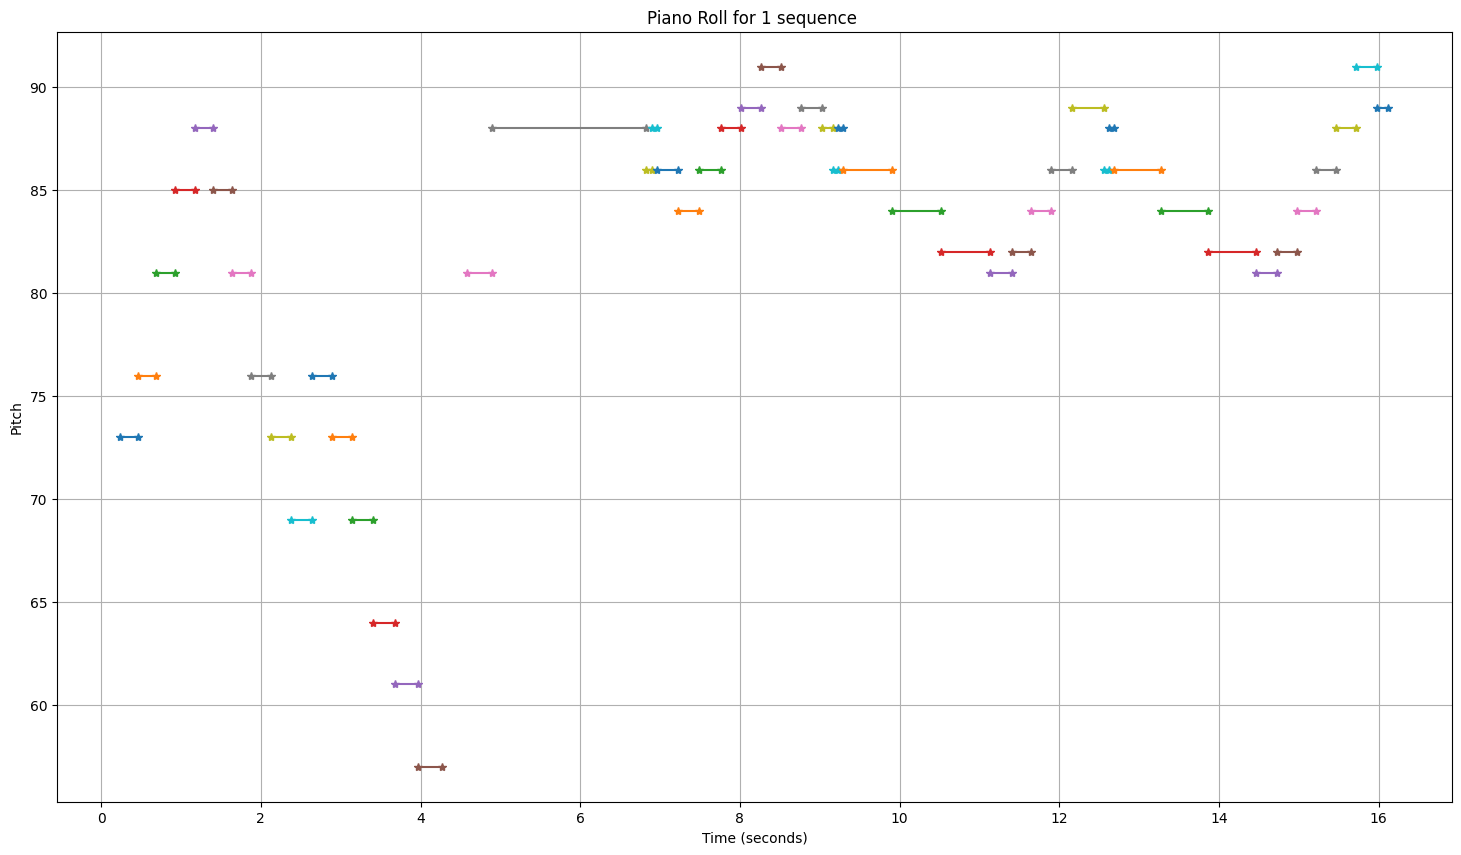

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def sequence_to_dataframe(sequence):
    pitches = []
    starts = []
    ends = []

    time = 0.0  # Start time
    for pitch, duration, step in sequence:
        time += step
        start = time
        end = start + duration

        pitches.append(pitch)
        starts.append(start)
        ends.append(end)

    df = pd.DataFrame({
        "Pitch": pitches,
        "Start": starts,
        "End": ends
    })
    return df

def plotting_piano_rolls(notes: pd.DataFrame, count = None):
    if count:
        title = f"Piano Roll for first {count} notes"
    else:
        title = "Piano Roll for 1 sequence "
        count = notes.shape[0]
    
    plt.figure(figsize=(18, 10))
    plot_pitch = np.stack([notes['Pitch'], notes['Pitch']], axis=0)
    plot_start_end = np.stack([notes['Start'], notes['End']], axis=0)
    
    plt.plot(plot_start_end[:, :count], plot_pitch[:, :count], marker='*')
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Pitch')
    plt.grid(True)
    plt.show()

sequence_df = sequence_to_dataframe(sequences[1])
plotting_piano_rolls(sequence_df)


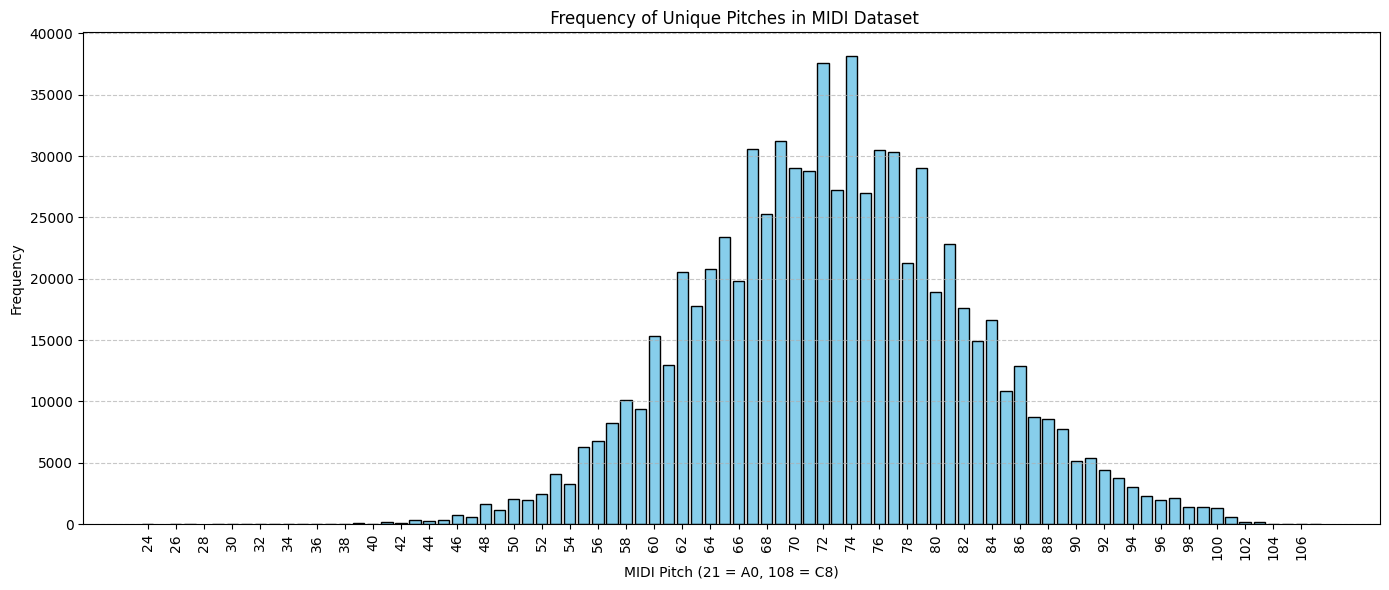

In [146]:
from collections import Counter

# Flatten all sequences to extract pitches
all_pitches = [note[0] for seq in sequences for note in seq]

# Count frequency of each pitch
pitch_counts = Counter(all_pitches)

# Sort pitches for better plotting
sorted_pitches = sorted(pitch_counts.items())
pitches, counts = zip(*sorted_pitches)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(pitches, counts, color="skyblue", edgecolor="black")
plt.xlabel("MIDI Pitch (21 = A0, 108 = C8)")
plt.ylabel("Frequency")
plt.title(" Frequency of Unique Pitches in MIDI Dataset")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(np.arange(min(pitches), max(pitches)+1, 2), rotation=90)
plt.tight_layout()
plt.show()


##  MIDI Sequence Preprocessing for LSTM Training

This function prepares MIDI note sequences for input into an LSTM model by filtering, normalizing, padding, and splitting the data.

###  Function: `preprocess_data(sequences, pitch_range=(21, 108), pad=True, min_occurrence=100)`

###  Parameters:
- **`sequences`**: List of note sequences (each sequence is a list of `[pitch, duration, step]`).
- **`pitch_range`** *(tuple)*: Acceptable range of MIDI pitches (default: A0 to C8).
- **`pad`** *(bool)*: Whether to pad sequences to equal length (default: `True`).
- **`min_occurrence`** *(int)*: Minimum number of times a pitch must occur to be retained (default: `100`).

###  Processing Steps:

1. **Filter Invalid Pitches**  
   Removes sequences with notes outside the specified MIDI pitch range.

2. **Count Pitch Occurrences**  
   Counts how often each pitch appears across all valid sequences.

3. **Remove Rare Pitches**  
   Filters out sequences containing pitches that appear less than `min_occurrence` times.

4. **Pad Sequences (Optional)**  
   Pads sequences to the same length for batch processing.

5. **Normalize Features**  
   - **Pitch** is min-max scaled between 0 and 1.  
   - **Duration** and **step** are log-transformed (`log1p`) and normalized.

6. **Split Data**  
   Divides data into:
   - 70% training
   - 15% validation
   - 15% test

###  Returns:
- `X_train`: Training data  
- `X_val`: Validation data  
- `X_test`: Test data

---

###  Example Usage:
```python
X_train, X_val, X_test = preprocess_data(sequences)
```


In [78]:
from collections import Counter
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

def preprocess_data(sequences, pitch_range=(21, 108), pad=True, min_occurrence=100):
    """Preprocess MIDI note sequences for LSTM model training"""

    # Step 1: Filter out sequences with any invalid pitches
    valid_sequences = []
    for seq in sequences:
        if all(pitch_range[0] <= note[0] <= pitch_range[1] for note in seq):
            valid_sequences.append(seq)

    print(f"Filtered out {len(sequences) - len(valid_sequences)} sequences with invalid pitches.")
    
    # Step 2: Count pitch occurrences across all sequences
    pitch_counts = Counter()
    for seq in valid_sequences:
        for note in seq:
            pitch_counts[int(note[0])] += 1
    
    # Step 3: Determine valid pitches that occur at least min_occurrence times
    valid_pitches = {p for p, count in pitch_counts.items() if count >= min_occurrence}
    print(f"Keeping {len(valid_pitches)} pitches with ≥ {min_occurrence} occurrences.")

    # Step 4: Remove sequences that contain any rare pitches
    filtered_sequences = []
    for seq in valid_sequences:
        if all(int(note[0]) in valid_pitches for note in seq):
            filtered_sequences.append(seq)

    print(f"Filtered out {len(valid_sequences) - len(filtered_sequences)} sequences with rare pitches.")

    # Step 5: Pad sequences (optional)
    if pad:
        sequences_array = pad_sequences(filtered_sequences, dtype='float32', padding='post')
    else:
        sequences_array = np.array(filtered_sequences, dtype=np.float32)

    # Step 6: Normalize
    pitch_min, pitch_max = pitch_range
    sequences_array[:, :, 0] = (sequences_array[:, :, 0] - pitch_min) / (pitch_max - pitch_min)

    duration_log = np.log1p(sequences_array[:, :, 1])
    step_log = np.log1p(sequences_array[:, :, 2])
    sequences_array[:, :, 1] = duration_log / np.max(duration_log)
    sequences_array[:, :, 2] = step_log / np.max(step_log)

    # Step 7: Train/Validation/Test Split
    X_train, X_temp = train_test_split(sequences_array, test_size=0.3, random_state=42)
    X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

    return X_train, X_val, X_test


X_train, X_val, X_test = preprocess_data(sequences)

Filtered out 0 sequences with invalid pitches.
Keeping 63 pitches with ≥ 100 occurrences.
Filtered out 138 sequences with rare pitches.


##  LSTM-Based Pitch Prediction Model for MIDI Generation

This model is designed to predict the next MIDI **pitch** value in a sequence using a multi-layered LSTM architecture.

###  Function: `build_model(seq_length=50)`

###  Parameters:
- **`seq_length`** *(int)*: Length of the input sequence (number of time steps per training sample).

###  Architecture Overview:
```text
Input Shape: (seq_length, 3)  →  [pitch, duration, step]
```

1. **`Masking` Layer**  
   Ignores padded values (`0.0`) in variable-length sequences.

2. **Bidirectional LSTM Layers**  
   - `Bi-LSTM(512)`: First recurrent layer with mild dropout (0.1).  
   - `Bi-LSTM(256)`: Second layer with stronger dropout (0.2).

3. **Unidirectional LSTM Layer**  
   - `LSTM(128)`: Final recurrent layer to compress information.

4. **Output Layer (Pitch Prediction)**  
   - `Dense(88, activation='softmax')`: Predicts the probability distribution over **88 piano keys** (MIDI notes 21–108).

###  Output:
- A tensor of shape **(seq_length, 88)** representing pitch class probabilities at each time step.



In [65]:
def build_model(seq_length=50):
    inputs = Input(shape=(seq_length, 3))
    
    # Masking layer for variable-length sequences
    x = Masking(mask_value=0.0)(inputs)
    
    # LSTM layers
    x = Bidirectional(LSTM(512,dropout=0.1, return_sequences=True))(x)
    x = Bidirectional(LSTM(256,dropout=0.2, return_sequences=True))(x)  
    x = LSTM(128, return_sequences=True)(x)  
    pitch_out = Dense(88, activation='softmax', name='pitch')(x)  # 88 piano keys

    
    model = Model(inputs=inputs, outputs=pitch_out)
    
    
    
    return model

model = build_model()
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 50, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_14        │ (None, 50, 3)     │          0 │ input_layer_12[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_12          │ (None, 50, 3)     │          0 │ input_layer_12[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_16 (Any)        │ (None, 50)        │          0 │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_13    │ (None, 50, 1024)  │  2,113,536 │ masking_12[0][0], │
│ (Bidirectional)     │                   │            │ any_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_14    │ (None, 50, 512)   │  2,623,488 │ bidirectional_13… │
│ (Bidirectional)     │                   │            │ any_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ (None, 50, 128)   │    328,192 │ bidirectional_14… │
│                     │                   │            │ any_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 50, 88)    │     11,352 │ lstm_38[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,076,568 (19.37 MB)

 Trainable params: 5,076,568 (19.37 MB)

 Non-trainable params: 0 (0.00 B)

## LSTM Model Training for MIDI Pitch Prediction

###  Target:
Train the model to predict pitch values from MIDI sequences using LSTM with time-shifted supervision.

---

###  Data Generator

- **X**: Input sequence (50 time steps).
- **y_pitch**: Normalized and scaled to [0–87] for 88 MIDI notes.
- **y_duration**, **y_step**: Continuous targets (can be used in a multi-output model).

---

###  Callbacks

- **ReduceLROnPlateau**: Lowers learning rate if validation loss plateaus.
- **ModelCheckpoint**: Saves the best model based on validation accuracy.
- **EarlyStopping**: Stops training early if accuracy doesn't improve.

---

###  Model Compilation & Training

- loss : `sparse_categorical_crossentropy`
- optimizer : `adam`
- Only **pitch prediction** is being trained here.
- Duration and step data are being prepared but not yet used as model outputs.



In [66]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

def data_generator(data, batch_size=32):
    while True:
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            
            X = batch[:,:-1]  

            y_pitch = np.round(batch[:, 1:, 0] * 87).astype(np.int32)  
            y_duration = batch[:, 1:, 1][..., np.newaxis].astype(np.float32)  
            y_step = batch[:, 1:, 2][..., np.newaxis].astype(np.float32)      
            yield X, {'pitch':y_pitch,'duration':y_duration,'step':y_step}
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
checkpoint = ModelCheckpoint(
    'music_model.keras',
    save_best_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max'
)

early_stop = EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor='val_sparse_categorical_accuracy'
)

# Training
model.compile(
    loss={
        'pitch': 'sparse_categorical_crossentropy'
    },
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics={
        'pitch': ['sparse_categorical_accuracy']  
    }
)

history = model.fit(
    data_generator(X_train, batch_size=32),
    steps_per_epoch=len(X_train)//32,
    epochs=100,
    validation_data=data_generator(X_val),
    validation_steps=len(X_val)//32,
    callbacks=[checkpoint,early_stop,lr_schedule]
)

Epoch 1/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 3.7441 - sparse_categorical_accuracy: 0.0487 - val_loss: 3.6874 - val_sparse_categorical_accuracy: 0.0473 - learning_rate: 0.0010
Epoch 2/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 3.6700 - sparse_categorical_accuracy: 0.0488 - val_loss: 3.6871 - val_sparse_categorical_accuracy: 0.0472 - learning_rate: 0.0010
Epoch 3/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 3.6690 - sparse_categorical_accuracy: 0.0489 - val_loss: 3.6835 - val_sparse_categorical_accuracy: 0.0475 - learning_rate: 0.0010
Epoch 4/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 3.6684 - sparse_categorical_accuracy: 0.0488 - val_loss: 3.6847 - val_sparse_categorical_accuracy: 0.0473 - learning_rate: 0.0010
Epoch 5/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 3.6699 - sparse_categorical_accuracy: 0.0489 - val_loss: 3.6863 - val_sparse_categorical_accuracy: 0.0471 - learning_rate: 0.0010
Epoch 6/100
318/318 ━━━━━━━━━━━━━━━

## Validation and training `loss`  & `accuracy` plots

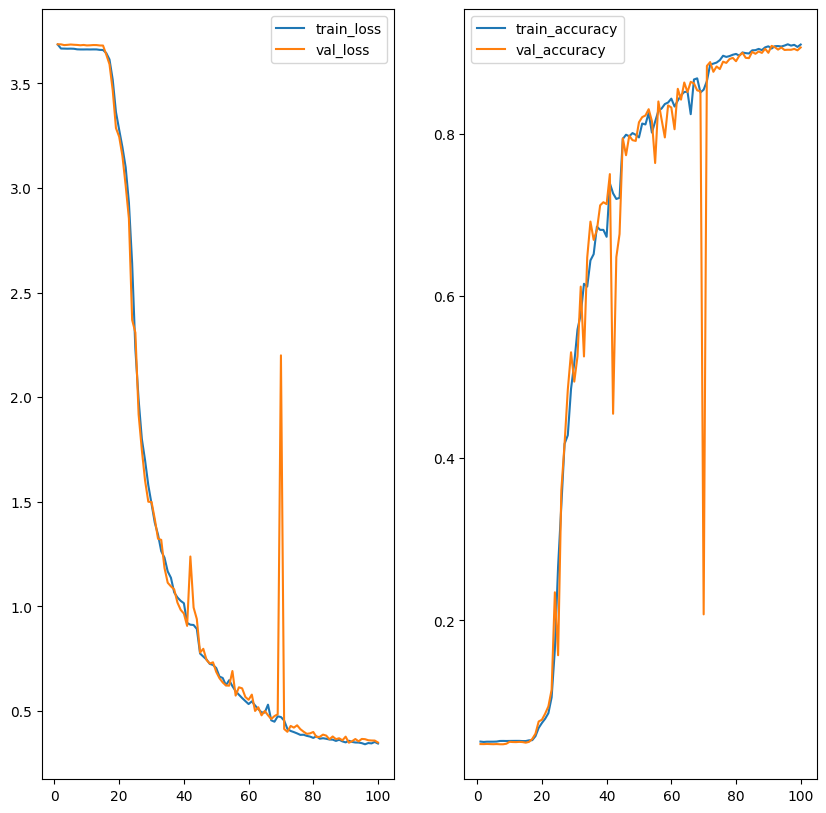

In [68]:
train_loss=history.history['loss']
train_accuracy=history.history['sparse_categorical_accuracy']
val_loss=history.history['val_loss']
val_accuracy=history.history['val_sparse_categorical_accuracy']
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(1,101),train_loss,label='train_loss')
plt.plot(range(1,101),val_loss,label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,101),train_accuracy,label='train_accuracy')
plt.plot(range(1,101),val_accuracy,label='val_accuracy')
plt.legend()
plt.show()

##  Duration & Step Prediction Model (LSTM)

This model predicts the **duration** and **step size** of notes in a MIDI sequence using a BiLSTM-based architecture.

---

###  Architecture
```python
def build_duration_step_model(seq_length=50):
    inputs = Input(shape=(seq_length, 3))

    x = Masking(mask_value=0.)(inputs)
    x = Bidirectional(LSTM(256, dropout=0.4, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = LSTM(256, dropout=0.4, return_sequences=True)(x)

    # Output heads
    dur_out = Dense(1, activation='sigmoid', name='duration')
    step_out = Dense(1, activation='sigmoid', name='step')

    duration = dur_out(x)
    step = step_out(x)

    model = Model(inputs=inputs, outputs=[duration, step])
    return model
```

---

###  Notes

- **Input shape**: `(batch, 50, 3)` — each time step contains `[pitch, duration, step]`.
- **Masking**: Handles padded sequences.
- **Bidirectional + Stacked LSTM**: Captures temporal context from both directions.
- **Output**:
  - `duration`: Predicts normalized duration (regression).
  - `step`: Predicts normalized step size (regression).
- **Activation**: `sigmoid` is used assuming the values are scaled between 0 and 1.

---

###  Summary


In [8]:
def build_duration_step_model(seq_length=50):
    inputs = Input(shape=(seq_length, 3))

    x = Masking(mask_value=0.)(inputs)
    x = Bidirectional(LSTM(256, dropout=0.4, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = LSTM(256, dropout=0.4, return_sequences=True)(x)

    # Output heads
    dur_out = Dense(1, activation='sigmoid', name='duration')
    step_out = Dense(1, activation='sigmoid', name='step')

    duration = dur_out(x)
    step = step_out(x)

    model = Model(inputs=inputs, outputs=[duration, step])
    return model

model_ds = build_duration_step_model()
model_ds.summary()

I0000 00:00:1744614391.835050   75025 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50, 3)     │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 50, 3)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 50)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 512)   │    532,480 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 512)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50, 256)   │    787,456 │ dropout[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 50, 1)     │        257 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 50, 1)     │        257 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,320,450 (5.04 MB)

 Trainable params: 1,320,450 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

##  Training: Duration & Step Model

This section trains the **duration** and **step** prediction heads using a custom data generator and `Mean Squared Error` loss.

---

###  Data Generator
Shifts target outputs by one timestep (for sequence prediction).



---

###  Model Compilation & Training Loop


- **Loss**: MSE (Mean Squared Error)
- **Metrics**: MAE (Mean Absolute Error)
- **Optimizer**: Adam with low learning rate `0.0001`
- **Checkpoint**: Best model saved based on validation loss


In [9]:
def data_generator_duration_step(data, batch_size=32):
    while True:
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            X = batch[:, :-1, :]
            y_duration = batch[:, 1:, 1][..., np.newaxis].astype(np.float32)
            y_step = batch[:, 1:, 2][..., np.newaxis].astype(np.float32)

            yield X, {
                'duration': y_duration,
                'step': y_step
            }

model_ds.compile(
    loss={
        'duration': 'mean_squared_error',
        'step': 'mean_squared_error',
    },
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics={
        'duration': ['mae'],
        'step': ['mae']
    }
)
  # reuse previous callbacks if desired
ds_checkpoint=ModelCheckpoint('ds_model.keras',save_best_only=True,monitor='val_loss')
history_ds = model_ds.fit(
    data_generator_duration_step(X_train, batch_size=64),
    steps_per_epoch=len(X_train)//64,
    epochs=20,
    validation_data=data_generator_duration_step(X_val),
    validation_steps=len(X_val)//64,
    callbacks=[ds_checkpoint]
)


Epoch 1/20


I0000 00:00:1744614405.287308   76728 cuda_dnn.cc:529] Loaded cuDNN version 90300


160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - duration_loss: 0.0698 - duration_mae: 0.1934 - loss: 0.1384 - step_loss: 0.0687 - step_mae: 0.1863 - val_duration_loss: 0.0017 - val_duration_mae: 0.0285 - val_loss: 0.0038 - val_step_loss: 0.0021 - val_step_mae: 0.0286
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - duration_loss: 0.0017 - duration_mae: 0.0285 - loss: 0.0038 - step_loss: 0.0021 - step_mae: 0.0290 - val_duration_loss: 0.0017 - val_duration_mae: 0.0288 - val_loss: 0.0038 - val_step_loss: 0.0021 - val_step_mae: 0.0290
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - duration_loss: 0.0016 - duration_mae: 0.0283 - loss: 0.0037 - step_loss: 0.0021 - step_mae: 0.0289 - val_duration_loss: 0.0016 - val_duration_mae: 0.0283 - val_loss: 0.0037 - val_step_loss: 0.0021 - val_step_mae: 0.0282
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - duration_loss: 0.0016 - duration_mae: 0.0283 - loss: 0.0037 - step_loss: 0.0021 - step_mae: 0.0288 - val_duration_loss: 0.0017 - v

## Training and validation `loss` & `accuracy` for <br>`duration` & `step` predictions

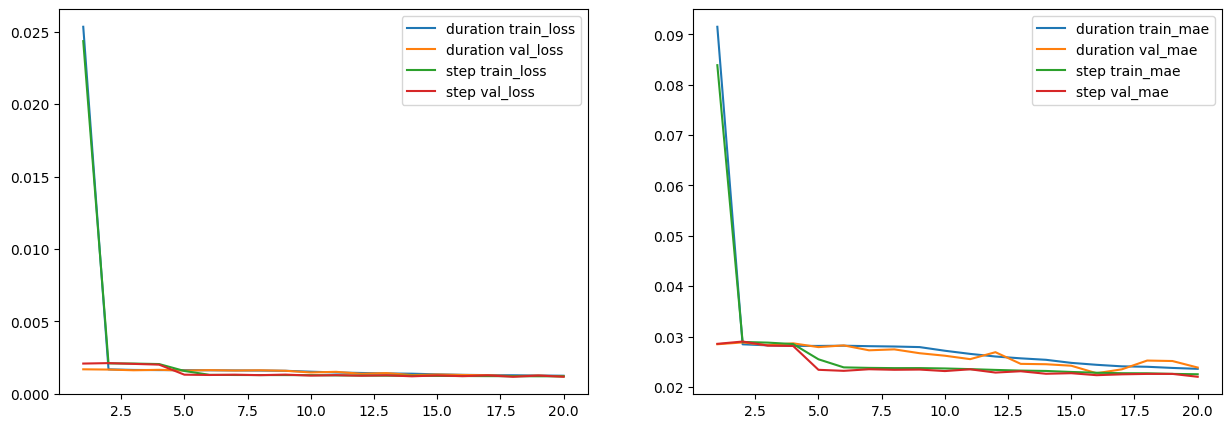

In [12]:
ds_train_loss=history_ds.history['duration_loss']
ds_train_accuracy=history_ds.history['duration_mae']
ds_val_loss=history_ds.history['val_duration_loss']
ds_val_accuracy=history_ds.history['val_duration_mae']
step_train_loss=history_ds.history['step_loss']
step_train_accuracy=history_ds.history['step_mae']
step_val_loss=history_ds.history['val_step_loss']
step_val_accuracy=history_ds.history['val_step_mae']

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(1,21),ds_train_loss,label='duration train_loss')
plt.plot(range(1,21),ds_val_loss,label='duration val_loss')
plt.plot(range(1,21),step_train_loss,label='step train_loss')
plt.plot(range(1,21),step_val_loss,label='step val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,21),ds_train_accuracy,label='duration train_mae')
plt.plot(range(1,21),ds_val_accuracy,label='duration val_mae')
plt.plot(range(1,21),step_train_accuracy,label='step train_mae')
plt.plot(range(1,21),step_val_accuracy,label='step val_mae')

plt.legend()
plt.show()

# Music Generation with Pitch and Duration/Step Models

This approach generates music by predicting **pitch**, **duration**, and **step** using two separate models: a **pitch model** (for pitch prediction) and a **duration-step model** (for predicting duration and step values).

### Functionality

- **Pitch Prediction**: The pitch is sampled from the model’s output distribution.
- **Duration and Step Prediction**: These values are predicted by the **duration-step model** and clipped to ensure safe values.
- The function combines these predictions into a generated sequence of music.






In [127]:
def generate_music_using_two_models(pitch_model, ds_model, seed_sequence, steps=200, temperature=0.7):
    """
    Generate new music (pitch, duration, step) from a seed sequence.
    `seed_sequence` should be of shape (50, 3) — [pitch, duration, step], all normalized.
    """
    generated = seed_sequence.copy()

    for _ in range(steps):
        # Prepare input: last 50 notes
        inputs = generated[-50:][np.newaxis, :]  # shape: (1, 50, 3)

        # Predict pitch probabilities
        pitch_probs = pitch_model.predict(inputs, verbose=0)  # shape: (1, 50, 88)
        pitch_probs_last = pitch_probs[0, -1]  # shape: (88,)

        # Apply temperature sampling
        pitch_logits = np.log(pitch_probs_last + 1e-8) / temperature
        pitch_exp = np.exp(pitch_logits)
        pitch_probs_temp = pitch_exp / np.sum(pitch_exp)

        # Sample from pitch distribution
        sampled_pitch_class = np.random.choice(np.arange(88), p=pitch_probs_temp)
        normalized_pitch = sampled_pitch_class / 87.0  # since 88 classes (0 to 87)

        # Predict duration and step (normalized values)
        duration_pred, step_pred = ds_model.predict(inputs, verbose=0)
        predicted_duration = float(duration_pred[0, -1, 0])
        predicted_step = float(step_pred[0, -1, 0])

        # Clip values for safety
        predicted_duration = np.clip(predicted_duration, 0.0, 0.5)
        predicted_step = np.clip(predicted_step, 0.02, 1.0)

        # Combine new note: shape (1, 3)
        new_note = np.array([[normalized_pitch, predicted_duration, predicted_step]])
        generated = np.vstack([generated, new_note])

    return generated


# Example usage
music_model=tf.keras.models.load_model('music_model.keras')
ds_model=tf.keras.models.load_model('ds_model.keras')
seed_idx = np.random.randint(0, len(X_test))
seed_sequence = X_test[seed_idx][:50] 
generated_using_both_models = generate_music_using_two_models(music_model,ds_model, seed_sequence, steps=100, temperature=0.3)


# Music Generation with Only Pitch Model

This approach generates music by using only the **pitch model** for pitch prediction. The **duration** and **step** values for all new notes are taken as averages from the seed sequence.

### Functionality

- **Pitch Prediction**: The pitch is sampled from the model’s output distribution using temperature sampling.
- **Duration and Step**: These values are taken from the **average duration** and **average step** of the seed sequence, rather than predicting them using a separate model.




In [128]:
def generate_music_using_one_model(pitch_model, seed_sequence, steps=200, temperature=0.7):
    """
    Generate new music (pitch, duration, step) from a seed sequence.
    `seed_sequence` should be of shape (50, 3) — [pitch, duration, step], all normalized.
    """
    generated = seed_sequence.copy()

    # Calculate average duration and step from the seed sequence
    avg_duration = np.mean(seed_sequence[:, 1])  # average of duration column
    avg_step = np.mean(seed_sequence[:, 2])      # average of step column

    for _ in range(steps):
        # Prepare input: last 50 notes
        inputs = generated[-50:][np.newaxis, :]  # shape: (1, 50, 3)

        # Predict pitch probabilities
        pitch_probs = pitch_model.predict(inputs, verbose=0)  # shape: (1, 50, 88)
        pitch_probs_last = pitch_probs[0, -1]  # shape: (88,)

        # Apply temperature sampling
        pitch_logits = np.log(pitch_probs_last + 1e-8) / temperature
        pitch_exp = np.exp(pitch_logits)
        pitch_probs_temp = pitch_exp / np.sum(pitch_exp)

        # Sample from pitch distribution
        sampled_pitch_class = np.random.choice(np.arange(88), p=pitch_probs_temp)
        normalized_pitch = sampled_pitch_class / 87.0  # since 88 classes (0 to 87)

        # Use the average duration and step from the seed sequence for all new notes
        predicted_duration = avg_duration  # use average duration
        predicted_step = avg_step        # use average step

        # Clip values for safety
        predicted_duration = np.clip(predicted_duration, 0.0, 0.5)
        predicted_step = np.clip(predicted_step, 0.02, 1.0)

        # Combine new note: shape (1, 3)
        new_note = np.array([[normalized_pitch, predicted_duration, predicted_step]])
        generated = np.vstack([generated, new_note])

    return generated


# Example usage
music_model = tf.keras.models.load_model('music_model.keras')
generated_using_only_pitch_model = generate_music_using_one_model(music_model, seed_sequence, steps=100, temperature=0.3)


# Convert Generated Sequence to MIDI

This function converts a generated sequence of normalized `[pitch, duration, step]` values into a standard `.mid` file using the PrettyMIDI library.

### Function: `sequence_to_midi`

In [140]:
import random
def sequence_to_midi(sequence, filename="generated.mid"):
    """Convert full (pitch, duration, step) sequence to MIDI"""
    import pretty_midi

    # Denormalize all features
    pitches = sequence[:,0] * 87 + 21  # MIDI pitch in range [21, 108]
    durations = np.expm1(sequence[:,1] * 5)  # Undo log1p and scale
    steps = np.expm1(sequence[:,2] * 5)      # Undo log1p and scale
    # Initialize MIDI
         
    midi = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    instrument = pretty_midi.Instrument(program=piano_program)

    # Track current time
    time = 0.0

    for pitch,duration,step in zip(pitches,durations,steps):
        pitch = int(np.clip(pitch, 21, 108))  # Ensure it's in valid range

        start_time = time + step
        end_time = start_time + duration

        note = pretty_midi.Note(
            velocity=100,
            pitch=pitch,
            start=start_time,
            end=end_time
        )
        instrument.notes.append(note)

        time = start_time  # update for next note relative to new start

    midi.instruments.append(instrument)
    midi.write(filename)
    return filename

# Convert and play
output_file1 = sequence_to_midi(generated_using_both_models, filename="generated1.mid")
output_file2 = sequence_to_midi(generated_using_only_pitch_model, filename="generated2.mid")

print(f"Generated MIDI saved to {output_file1,output_file2}")

Generated MIDI saved to ('generated1.mid', 'generated2.mid')


## MIDI Visualization: Pitch Over Time

### This visualization helps analyze how the AI-generated music evolves in terms of pitch and rhythm.


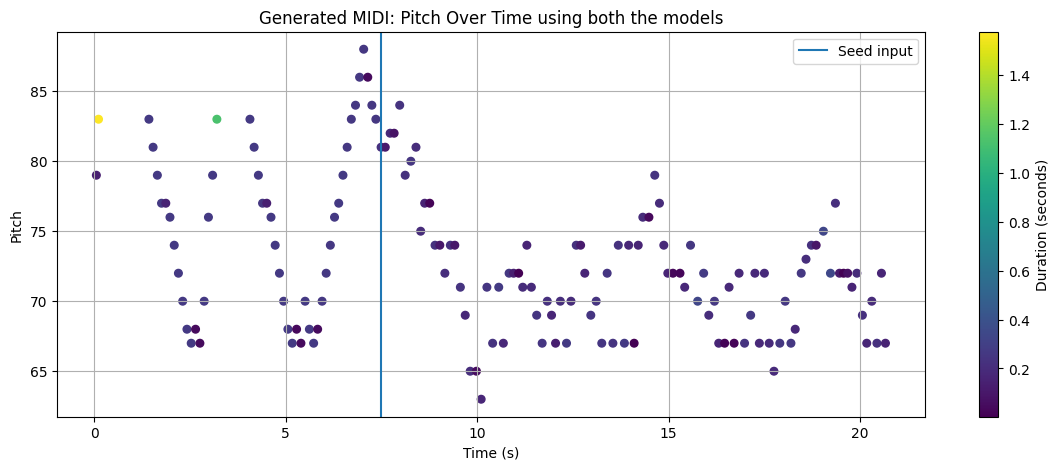

In [143]:
import pretty_midi
import matplotlib.pyplot as plt
import numpy as np

# Load MIDI
midi = pretty_midi.PrettyMIDI("generated1.mid")

# Collect note info
notes = []
for instrument in midi.instruments:
    for note in instrument.notes:
        notes.append((note.start, note.pitch, note.end - note.start))

# Convert to array
notes = np.array(notes)

# Plot
plt.figure(figsize=(14, 5))
plt.scatter(notes[:, 0], notes[:, 1], c=notes[:, 2], cmap="viridis", s=30)
plt.colorbar(label="Duration (seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Pitch")
plt.title("Generated MIDI: Pitch Over Time using both the models")
plt.axvline(notes[50,0],label="Seed input")
plt.grid(True)
plt.legend()
plt.show()

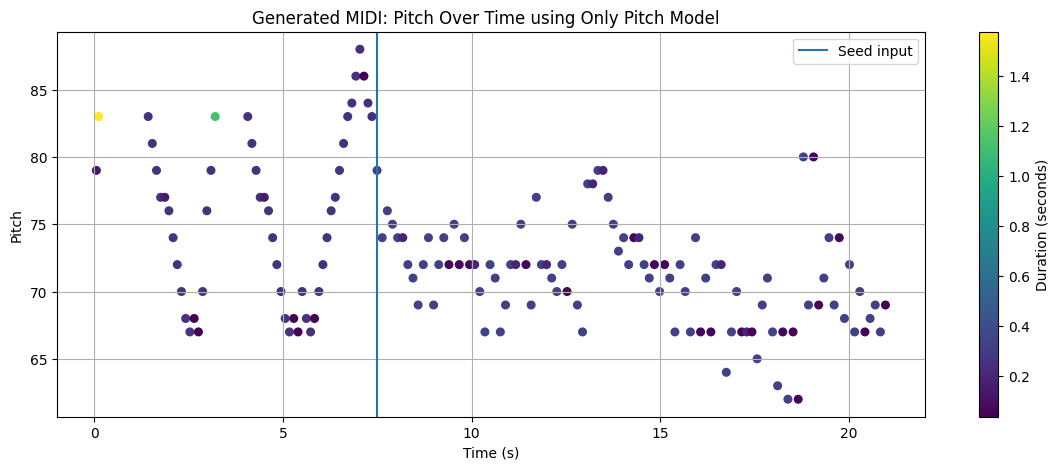

In [144]:
import pretty_midi
import matplotlib.pyplot as plt
import numpy as np

# Load MIDI
midi = pretty_midi.PrettyMIDI("generated2.mid")

# Collect note info
notes = []
for instrument in midi.instruments:
    for note in instrument.notes:
        notes.append((note.start, note.pitch, note.end - note.start))

# Convert to array
notes = np.array(notes)

# Plot
plt.figure(figsize=(14, 5))
plt.scatter(notes[:, 0], notes[:, 1], c=notes[:, 2], cmap="viridis", s=30)
plt.colorbar(label="Duration (seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Pitch")
plt.title("Generated MIDI: Pitch Over Time using Only Pitch Model  ")
plt.axvline(notes[50,0],label="Seed input")
plt.grid(True)
plt.legend()
plt.show()